<a href="https://colab.research.google.com/github/iskode/blog/blob/master/_notebooks/2021-06-22-image_classification_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "**Breast Cancer Diagnosis with fastai part 1**:"

> "Data Access, Exploration and Preparation"

- toc:true- branch: master
- badges: true
- comments: true
- author: Ismaël Koné
- categories: [fastpages, jupyter]
- hide: false
- search_exclude: true
- metadata_key1: breast-cancer
- metadata_key2: bach-challenge-2018
- metadata_key3: data-preparation
- metadata_key4: validation-set
- metadata_key5: fastai

# **Breast Image Classification Project part 1**: Data Exploration and Preparation

The dataset we use in this project comes from the 2018 BreAst Cancer Histology (BACH) Grand Challenge accessible at https://iciar2018-challenge.grand-challenge.org/download/ after registration and asking for accessing the dataset.

The challenge has two parts: 

1.   a classification image part
2.   a segmentation part

In the former, we have to classify high resolution [histology](https://en.wikipedia.org/wiki/Histology) images (2048 x 1536 pixels) into 4 categories: **Normal** , **Benign**, **Carcinoma In Situ** and **Carcinoma Invasive**. The dataset contains 400 images equidistributed among the 4 categories (100 per each).




The second part is the segmentation of the whole slide tissue, around 42113 x 62625 pixels, into the 4 groups above.

In our case, we are interested in the classification part. Perhaps the segmentation will be the subject of a future blog project.

In this blog, we are going to do the data preparation stuff :


*   Download the dataset
*   Do a minimal exploration to get a basic understanding
*   Partition the data into training and validation sets (but not so trivially !)
*   Set everything to make the training step with fastai library straightforward.







In [ ]:
# Download last version of fastai 
! pip install -Uqq --upgrade fastai

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import fastai
from fastai.vision.all import Path, Image
fastai.__version__

'2.4'

In this part, we will not train any model. We will use only the `Path` and `Image` modules from fastai. 

Why not just using `Path` from `pathlib` ?

Yeah you got me ! But fastai comes with some cutomizations over existing packages to make them more user-friendly. The single think like for now, as I'm still discovering fastai goodies, is being able to call `ls()` on a Path object from fastai as in bash. We will see that in action later.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



## Download the dataset

As mentioned in the beginning, you must go over the following steps to access to dataset:
  

1.   go to https://iciar2018-challenge.grand-challenge.org/download/ and create an account. You will be ask to enter a name and password or to use your google account (which is straightforward).
2.   fill in the form on the same webpage
3.   you should receive an email with your credentials: YOUR_USERNAME and YOUR_PASSWORD.


You will use those credentials in the cell below to download the dataset.

In [ ]:
dir="/content/gdrive/'My Drive'/'Colab Notebooks'/"

! cd {dir}; mkdir -p data/bach2018
! cd {dir}data/bach2018; wget --user=YOUR_USERNAME --password=YOUR_PASSWORD http://cdn1.i3s.up.pt/digitalpathology/ICIAR2018_BACH_Challenge.zip
! cd {dir}data/bach2018; wget --user=YOUR_USERNAME --password=YOUR_PASSWORD http://cdn1.i3s.up.pt/digitalpathology/ICIAR2018_BACH_Challenge_TestDataset.zip

In [ ]:
! cd {dir}data/bach2018; unzip ICIAR2018_BACH_Challenge.zip
! cd {dir}data/bach2018; unzip ICIAR2018_BACH_Challenge_TestDataset.zip

You don't see outputs on the cells above as I have done it in a separate notebook. But if you follow instructions, after running the cell below, you should get the same output. 

In [ ]:
def print_path(path:Path): 
    """
    prints contents of @path one per line.
    """
    for d in Path(path).ls(): print(d)
    
root_path = Path("gdrive/My Drive/Colab Notebooks/data/bach2018")
print_path(root_path)

gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge.zip
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge_TestDataset.zip
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge_TestDataset
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge


In [ ]:
data_path = root_path/"ICIAR2018_BACH_Challenge/Photos/"
print_path(root_path/"ICIAR2018_BACH_Challenge")
print("")
print_path(data_path)

gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/WSI
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos

gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/microscopy_ground_truth.csv
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/.DS_Store
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/InSitu
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/Invasive
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/Benign
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/Normal
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/all_data
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/data_splits.csv
gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/ICIAR2018_BACH_dataset_micro_patient.xlsx


We have two subfolders inside ICIAR2018_BACH_Challenge: WSI and Photos.
WSI contains images for the segmentation part and Photos contains images for the classification.

We can see 4 folders named after each category: **Normal**, **Invasive** for Carcinoma Invasive, **InSitu** for Carcinoma In Situ and **Benign**.

You should not see for now the last 3 lines. We will create them later.

Now we have all the data in place, let's create a partition and minimally explore them along the way.

## Basic exploration of the dataset

There is a section on the dataset website page which states the following:
 

> The patient-wise origin of each microscopy image is partially available on the following file. The anonimization process does not allow to retrieve the origin of all images, but it is safe to assume that all undentified images come from different patients of the identified ones.
>
> [View public_html/patient_microscopy on Dropbox](https://www.dropbox.com/sh/8un9pwrhtqu99r3/AADX3De88B_iJdDtp359X5jHa?dl=0).

This an ***incredible information for creating a good validation set***. We must pay attention to not put different images from the same patient in training and validation sets. Otherwise the trained model will likely predict it correctly as it has already seen this kind of images even if there are from different classes.


Now let's see the content of this excel files. Note that we found this file poorly formatted so we modify it manually to make it more easy to process. [Here](https://drive.google.com/file/d/1FFRB7bEwCFqMH3kEFTHmgKYFNyCe8KaP/view?usp=sharing) is our version of the excel file that we put in the main directory of the dataset.

In [ ]:
patient_info = pd.read_excel(data_path/"ICIAR2018_BACH_dataset_micro_patient.xlsx")
patient_info.head()

,Histology,Label,Patient
0,b001.tif,Benign,NaN
1,b002.tif,Benign,NaN
2,b003.tif,Benign,NaN
3,b004.tif,Benign,NaN
4,b005.tif,Benign,NaN


The `Patient` column holds anonymized patient `IDs`. Not all of them are provided as mentioned on the dataset website. 

Let's look at those patients with provided `IDs`.

In [ ]:
patient_info[patient_info.Patient.notnull()]

,Histology,Label,Patient
31,b032.tif,Benign,11.0
32,b033.tif,Benign,11.0
33,b034.tif,Benign,11.0
34,b035.tif,Benign,11.0
35,b036.tif,Benign,12.0
...,...,...,...
363,n064.tif,Normal,21.0
364,n065.tif,Normal,21.0
365,n066.tif,Normal,21.0
366,n067.tif,Normal,21.0


Let's define some utility functions to read an image from its row in the DataFrame.

We will mainly resize images as their resolution is high: 2048 x 1536 pixels.

gdrive/My Drive/Colab Notebooks/data/bach2018/ICIAR2018_BACH_Challenge/Photos/Benign/b032.tif


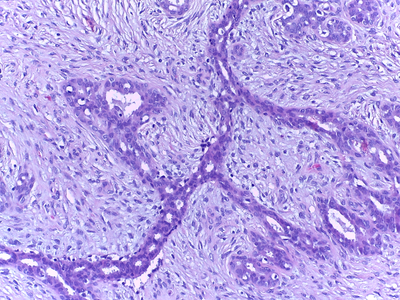

In [ ]:
def get_imfile(row:pd.DataFrame, path:Path=data_path):
    """
    Build a Path object from the DataFrame of 
    dataset patient info excel file 'ICIAR2018_BACH_dataset_micro_patient.xlsx'
    @row: a row of the DataFrame
    @data_path: a Path object of the excel file  
    """
    s, f = row['Label'], row['Histology']
    return path/f"{s+'/'+f}"


def open_resize(imfile:[str, Path], size:tuple=(400, 400)):
    """
    Returns an PIL.Image object from the file path @imfile
    resized to @size if it's not None/False.
    """
    img = Image.open(imfile)
    if size: img.thumbnail((400, 400), Image.ANTIALIAS)
    return img

path = get_imfile(patient_info.iloc[31], data_path)
print(path)
open_resize(path)

The `Patient` column holds `IDs` of patients. Some are not provided so we assume they come from different patients as mentioned on the dataset webpage.

Below we collect the number of images for each patient who has an `ID` (column `Patient` in the DataFrame) and create a dictionary of `ID` with associated number of images for those having more than one image. In order words, we collect patients who have many images in the dataset.

Total number of images from patients with provided ID: 140


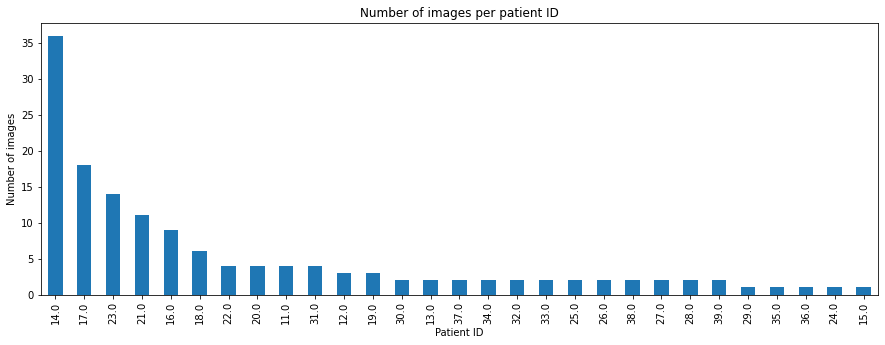

In [ ]:
vc = patient_info[patient_info.Patient.notnull()].Patient.value_counts()
display(vc.plot(kind='bar', figsize=(15, 5)))
plt.title("Number of images per patient ID")
plt.xlabel("Patient ID")
plt.ylabel('Number of images')

pids = vc.to_dict()
pids = {int(k):pids[k] for k in pids if pids[k]>1 }
print(f"Total number of images from patients with provided ID: {sum(pids.values())}")

We notice that patients with `IDs: 14, 17, 23, 21 16,` have nearly 10 images. In particular, patient with `ID = 14` has 36 images !

Let's look at the image distribution of this patient over category or label. 

Text(0, 0.5, 'Number of images')

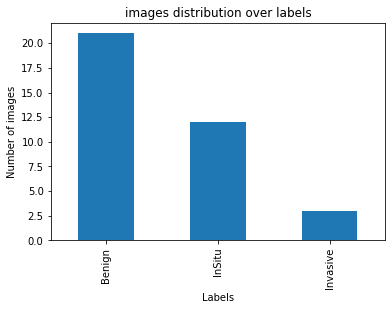

In [ ]:
patient_info[patient_info.Patient == 14].Label.value_counts().plot(kind='bar')
plt.title("images distribution over labels")
plt.xlabel("Labels")
plt.ylabel("Number of images")

Therefore, we will visualize images from these patients with many images across categories.

In [ ]:
def show_duplicate_images(patientID:int, figsize:tuple=(20,10)):
    """
    This method show images from a single patient whose
    id is provided @patientID. It shows at most 3 images per available
    associated label.
    """
    prows = patient_info[patient_info.Patient == patientID]
    labels = prows.Label.unique()
    images_label_min = min([prows[prows.Label == l].shape[0] for l in labels])
    n_images = min(3, images_label_min)
    fig, axes = plt.subplots(len(labels), n_images, figsize=figsize, constrained_layout = True)
    labelrows = {l:prows[prows.Label==l][:n_images] for l in labels}
    for i in range(n_images):
        for p, k in enumerate(labelrows):
            im = open_resize(get_imfile(labelrows[k].iloc[i]))
            if len(labels) == 1:
                axes[i].imshow(im)
                axes[i].set_title(k)
                axes[i].axis("off") 
            else:   
                axes[p][i].imshow(im)
                axes[p][i].set_title(k)
                axes[p][i].axis("off")
    
    # plt.subplot_tool()
    plt.show()


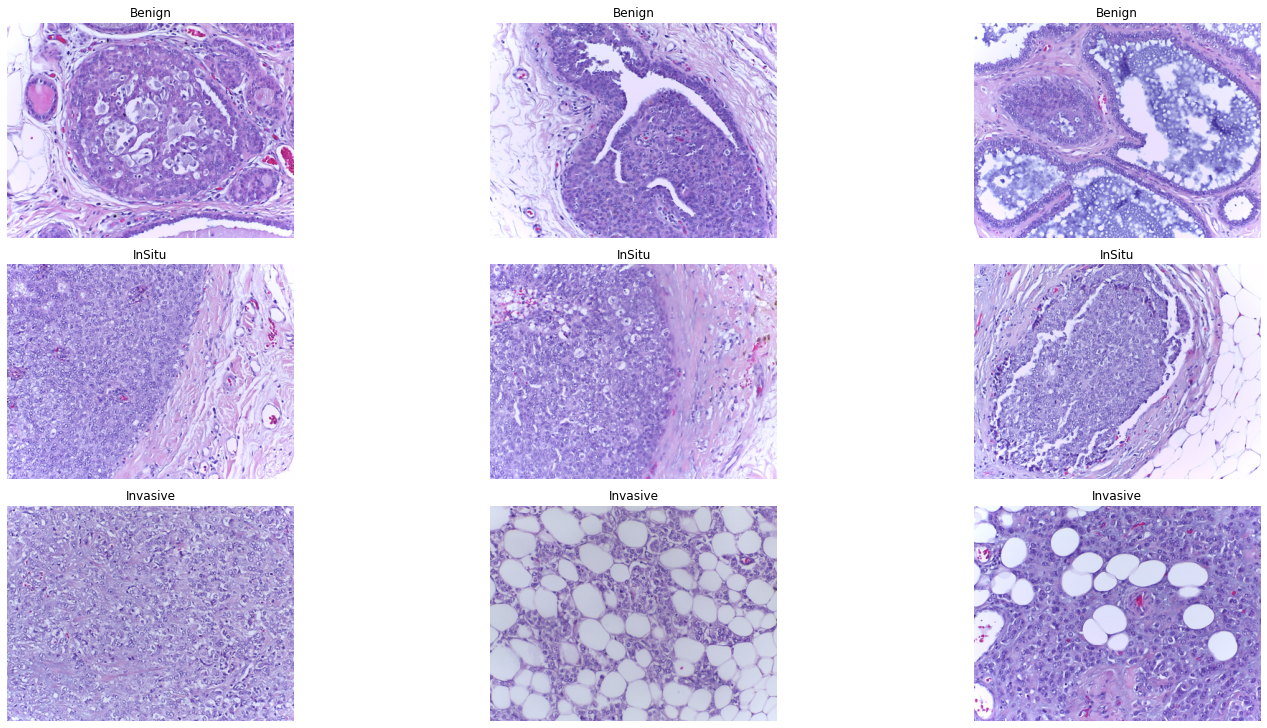

In [ ]:
show_duplicate_images(14)


These images from patient `ID = 14` tend to have high densities of dot(cell) purples with some gray balls. In few cases, we noticed firmly red areas that are mostly located  in gray areas including some gray balls. We notice this specificity across different labels with small variations.

In [ ]:
show_duplicate_images(17)    

Here,we notice a weak density of dot purples and images are less brighter than previous. Although the weak density can be attributed to `Normal` images, we see here that `Benign` images have much less density of purple dots than that of patient `ID = 14` previously seen. Additionally, the rightmost `Normal` image has a quite different structure: its background tends towards redish color.

So a high level pattern is surfacing: 

`Normal and Benign tend to have less density of dot purples comparing to Invasive and InSitu.`

We are doing human learning !

In [ ]:
show_duplicate_images(16)

These images from patient `ID = 16` have a different structure than those seen before. The background comes in two aspects: pink and light gray.Also there are localized dense areas of purple dots. Again, this pattern is present across labels with variations.


This exploration lets us learn more about breast histology images (domain knowledge) and the structure of this dataset.



1.   **Learning about breast histology images**:

> *    Normal and Benign images have less density of purple dots(cells) than Invasive and InSitu
* Normal and Benign have sometimes few localized dense areas of purple dots with latter being more dense than the former.
* The separation line between InSitu and Benign blurred so it must be challenging for a ML algo to be very accurate in this case.

We are not pathologists but that knowledge can guide our intuition while building our models.

2.   **The dataset structure learning for setting a good validation set**

This dataset has two high level features. It is distributed among label and among patients. Thus our validation set must take into account these features to avoid another bias. 

Yes another, because the data itself is biased by nature which the case for any dataset. We can't flip a coin to collect data among all stratifications within the world population (age, gender, place, health, social, ...) ! All the constraints in real life lead naturally to biases. 

> Biases are inherent in almost all datasets, But we are responsible for:
*  identifying and acknowledging them;
*  trying whenever possible to reduce them;
*  taking them into account when using or deploying resulting models.

Here the dataset is equidistributed among labels so must be our validation set. Additionally, after exploring images from patients with provided `ID`, it is crystal clear that setting a validation set by randomly selecting images across labels only can be a problem. There are two main risks:

1.   similar images from the same label of a single patient can be scattered between training and validation sets
2.   same case as 1. but at different labels.

In these cases, it would be easy for our model to predict those in the validation set as the model has already been trained on these kind of images and
this can lure that our model performs well while it is not.

That's why, in the next section we will build a validation set while ensuring that such leak doesn't occur.

## Build a robust validation set



Now we will write a method for selecting 20% of the validation set among patient with provided `IDs`. For each patient in this category, we grab all of its images in the dataset in order to avoid any leak.

Then we will grab the same percentage from the rest of the dataset.


### Grab images among patients with ID having at least 2 images

In [ ]:

def choose_vpids(pids, pv=0.2):
    """
    select @pv*100% of patients (@pids) with at least two images
    in the dataset
    Returns the list of those patients `ID` 
    """
    #reproducibility seed.
    np.random.seed(14)
    chosen = []
    nv = sum(pids.values())*pv
    total = 0
    while total < nv:
        id = np.random.choice(list(pids.keys()), 1 )[0]
        if id not in chosen: 
            chosen.append(id)
            total += pids[id]        
    return chosen

vpct = 0.2
vpids = choose_vpids(pids, pv=vpct)
{id:pids[id] for id in vpids}

{11: 4, 12: 3, 13: 2, 19: 3, 20: 4, 22: 4, 28: 2, 30: 2, 32: 2, 39: 2}

Above is a dictionary of patient ID and number of associated images that are included in the validation set. You can notice patient `ID = 14` which has 36 images or the like for example are not in the validation set. 

Why do we manage to avoid it ?

If images from this single patient are in the validation set.This means that our model is likely to correctly classify 36 images if it handle only one correctly as the distribution should be nearly the same like we've seen it before. We want to prevent our model to get a good score easily. Conversely, if our model can't handle it correctly, it may misclassified 36 images then. But we want a diversity in our validation set.

Now we add add a column namely `is_valid` to the DataFrame to mark rows belonging to training (0) and validation (1) sets.
This will set us for taking advantage of fastai which comes with many goodies to handle datasets with DataFrame or .csv/.xlsx files.


In [ ]:
patient_info["is_valid"] = 0
for v in vpids:
    patient_info.loc[patient_info.Patient == v, "is_valid"] = 1

Let's check that we effectively grab 20% of images from patients with provided `ID`.

In [ ]:
sum(pids.values())*0.2 == patient_info[patient_info.is_valid==1].is_valid.sum()

True

Now, we will grab 20% of data from other rows of the DataFrame i.e rows with no provided `ID`.  



### Grab images among patients without ID

First let's look at the distribution per label of the number of cumulative images from patients having at least two images in the dataset.

This will allow us to evaluate the number of remaining images and grab them among patient without ID.

In [ ]:
vcounts = pd.concat([patient_info[patient_info.Patient == v] for v in vpids]).Label.value_counts().to_dict()
vcounts

{'Benign': 13, 'InSitu': 1, 'Invasive': 11, 'Normal': 3}

Here, we shuffle rows of the DataFrame to avoid the ordering bias and use a seed number again for reproducibility.

In [ ]:
np.random.seed(7859)
patient_info = patient_info.sample(frac=1).reset_index(drop=True)

In [ ]:
n_classes = len(patient_info.Label.unique())
n = vpct*patient_info.shape[0]/n_classes
remain_ns = {k: int(n - vcounts[k]) for k in vcounts}
remain_ns

{'Benign': 7, 'InSitu': 19, 'Invasive': 9, 'Normal': 17}

Above are the remaining number of images per label to complete our validation set.

Below, we will randomly select these numbers of images for each label.

In [ ]:

for k in remain_ns:
    np.random.seed(4263)
    idxs = patient_info[(patient_info.Patient.isnull()) & (patient_info.Label==k)].index
    vidxs = np.random.choice(idxs, remain_ns[k], replace=False)
    patient_info.loc[vidxs, 'is_valid'] = 1


We check that the number of images in the validation set is correct and equidistributed among the 4 labels. 

In [ ]:
patient_info.drop(["Patient"], axis=1).groupby(['Label']).sum()

,is_valid
Label,
Benign,20
InSitu,20
Invasive,20
Normal,20


In the previous section, we define a function to get the image file from the DataFrame. Thus we will add a column which contains local path for each image so that using fastai will work directly.


In [ ]:
patient_info["fname"] = patient_info["Label"] +'/'+patient_info['Histology']
# patient_info["fprefix"] = patient_info["Histology"].apply(lambda x: x.split('.')[0]) 
display(patient_info.head())
patient_info.tail()

,Histology,Label,Patient,is_valid,fname
0,b001.tif,Benign,NaN,0,Benign/b001.tif
1,b002.tif,Benign,NaN,0,Benign/b002.tif
2,b003.tif,Benign,NaN,0,Benign/b003.tif
3,b004.tif,Benign,NaN,0,Benign/b004.tif
4,b005.tif,Benign,NaN,0,Benign/b005.tif


,Histology,Label,Patient,is_valid,fname
395,n096.tif,Normal,NaN,0,Normal/n096.tif
396,n097.tif,Normal,NaN,0,Normal/n097.tif
397,n098.tif,Normal,NaN,0,Normal/n098.tif
398,n099.tif,Normal,NaN,0,Normal/n099.tif
399,n100.tif,Normal,NaN,0,Normal/n100.tif


We will save our DataFrame that contains the result of this validation set building process.

In [ ]:
patient_info.to_csv(data_path/"data_splits.csv", index=False)

## Conclusion

we have done a basic image exploration which has given us a lay understanding of the data and inherent difficulties of the classification task. 
Additionally, we have built a least biased validation set which we hope is robust and will inform us about a fair performance of our up-coming models. 

The modelling part will be straightforward now that we have everything in place.

